In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import random
from typing import Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## BITNET IMPLEMENTATION 2

Using device: cuda
⚡ Improved BitNet Language Model ⚡
Data file not found, using sample text
Vocab size: 43
Characters: ['\n', ' ', "'", ',', '-', '.', 'A', 'E', 'H', 'L', 'O', 'P', 'S', 'T', 'W', 'a', 'b', 'c', 'd', 'e']...
Total tokens: 32180
Vocab size: 43
Dataset created: 31988 sequences
Model parameters: 10,758,223

🚀 Starting training...
Epoch 1/15, Batch 0/1000, Loss: 3.8146, LR: 0.000200
Epoch 1/15, Batch 50/1000, Loss: 2.9789, LR: 0.000200
Epoch 1/15, Batch 100/1000, Loss: 2.5591, LR: 0.000200
Epoch 1/15, Batch 150/1000, Loss: 2.4849, LR: 0.000200
Epoch 1/15, Batch 200/1000, Loss: 2.4243, LR: 0.000200
Epoch 1/15, Batch 250/1000, Loss: 2.3497, LR: 0.000200
Epoch 1/15, Batch 300/1000, Loss: 2.2886, LR: 0.000200
Epoch 1/15, Batch 350/1000, Loss: 2.2004, LR: 0.000200
Epoch 1/15, Batch 400/1000, Loss: 2.1493, LR: 0.000200
Epoch 1/15, Batch 450/1000, Loss: 2.1434, LR: 0.000200
Epoch 1/15, Batch 500/1000, Loss: 2.0540, LR: 0.000200
Epoch 1/15, Batch 550/1000, Loss: 1.9963, LR: 0.0002

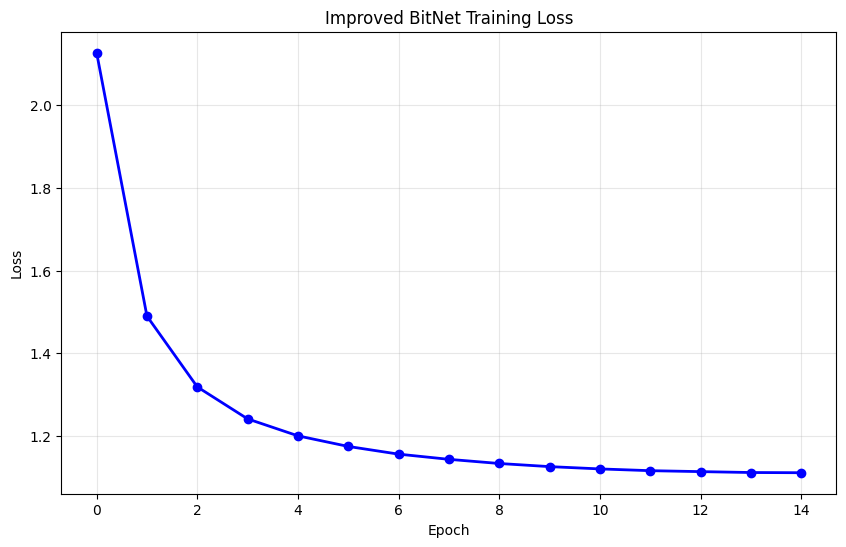


📝 Generating improved text samples...

🌟 Prompt: 'Once upon a time'
Generated: Once upon a time, in in a land the oprm in lag ceanature lived in in perfects baland tures and thepest ocean.
        Every day, she would walk through the enchanted 
------------------------------------------------------------

🌟 Prompt: 'In a magical forest'
Generated: n a magical forestand lar cretulies and learng their ancient wisdom.
        
        The forest was magical, filed with talking animals, glowing flowers, and treeees t
------------------------------------------------------------

🌟 Prompt: 'The princess discovered'
Generated: The princess discovered haby crestarestand small.
        
        One day, while practicing her spells, Luna discovered she had a special gift.
        She could understand
------------------------------------------------------------

🌟 Prompt: 'Long ago, there lived'
Generated: Long ago, there lived spracing he ha witat-cler s s, soled shered soulersthes bubers shau

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
import time
import os
import json
from typing import Optional

# Set device and optimize for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enable mixed precision for faster training
torch.backends.cudnn.benchmark = True

class ImprovedBitLinear(nn.Module):
    """
    Improved BitNet Linear Layer with better quantization and scaling
    """
    def __init__(self, in_features, out_features, bias=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Weight parameter - initialize with Xavier normal
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        nn.init.xavier_normal_(self.weight)
        
        # Optional bias
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        
        # Learnable scaling factors for better gradient flow
        self.weight_scale = nn.Parameter(torch.ones(1))
        self.eps = 1e-8

    def quantize_weights(self, w):
        """Improved weight quantization to {-1, 0, +1}"""
        # Calculate scale using mean absolute value for stability
        scale = w.abs().mean().clamp(min=self.eps)
        
        # Normalize weights
        w_norm = w / (scale + self.eps)
        
        # Quantize with improved thresholding
        # Use a learnable threshold or fixed threshold around 0.5
        threshold = 0.3  # Lower threshold for more active weights
        w_quant = torch.sign(w_norm) * (w_norm.abs() > threshold).float()
        
        return w_quant, scale

    def forward(self, x):
        # Quantize weights
        w_quant, w_scale = self.quantize_weights(self.weight)
        
        # Improved activation quantization - use tanh for smooth gradients
        # Instead of hard clipping, use a softer function
        x_norm = torch.tanh(x)  # Soft activation quantization
        
        # Linear transformation
        output = F.linear(x_norm, w_quant, self.bias)
        
        # Apply learned scaling
        output = output * w_scale * self.weight_scale
        
        return output

class ImprovedBitAttention(nn.Module):
    """Improved BitNet Attention with better stability"""
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.dim = dim
        self.head_dim = dim // heads
        self.scale = self.head_dim ** -0.5
        
        assert dim % heads == 0, "dim must be divisible by heads"
        
        # Use separate projections for better learning
        self.q_proj = ImprovedBitLinear(dim, dim)
        self.k_proj = ImprovedBitLinear(dim, dim)
        self.v_proj = ImprovedBitLinear(dim, dim)
        self.out_proj = ImprovedBitLinear(dim, dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, L, D = x.shape
        
        # Generate Q, K, V
        q = self.q_proj(x).view(B, L, self.heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, L, self.heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, L, self.heads, self.head_dim).transpose(1, 2)
        
        # Attention computation with improved stability
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale
        
        # Causal mask
        mask = torch.tril(torch.ones(L, L, device=x.device, dtype=torch.bool))
        attn_scores = attn_scores.masked_fill(~mask, float('-inf'))
        
        # Stable softmax
        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)
        
        # Handle potential NaN values
        attn_probs = torch.nan_to_num(attn_probs, nan=0.0)
        
        # Apply attention
        out = (attn_probs @ v).transpose(1, 2).contiguous().view(B, L, D)
        
        return self.out_proj(out)

class ImprovedBitMLP(nn.Module):
    """Improved BitNet MLP with better capacity"""
    def __init__(self, dim, expansion_factor=4, dropout=0.1):
        super().__init__()
        hidden_dim = int(dim * expansion_factor)
        
        self.fc1 = ImprovedBitLinear(dim, hidden_dim)
        self.fc2 = ImprovedBitLinear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Use SiLU/Swish activation for better gradients
        x = self.fc1(x)
        x = F.silu(x)  # SiLU activation (x * sigmoid(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ImprovedBitBlock(nn.Module):
    """Improved BitNet Transformer Block"""
    def __init__(self, dim, heads=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = ImprovedBitAttention(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp = ImprovedBitMLP(dim, expansion_factor=4, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # Pre-norm architecture with residual connections
        residual = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + residual
        
        residual = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.dropout(x)
        x = x + residual
        
        return x

class ImprovedBitNet(nn.Module):
    """Improved BitNet Language Model with better architecture"""
    def __init__(self, vocab_size, dim=256, depth=6, heads=8, max_len=512, dropout=0.1):
        super().__init__()
        self.dim = dim
        self.max_len = max_len
        self.vocab_size = vocab_size
        
        # Embeddings with better initialization
        self.token_emb = nn.Embedding(vocab_size, dim)
        self.pos_emb = nn.Embedding(max_len, dim)
        
        # Input dropout
        self.emb_dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            ImprovedBitBlock(dim, heads, dropout) 
            for _ in range(depth)
        ])
        
        # Output layers
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.head = nn.Linear(dim, vocab_size)  # Use regular linear for output
        
        # Initialize parameters
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
    
    def forward(self, x, targets=None):
        B, L = x.shape
        
        # Clamp sequence length
        if L > self.max_len:
            x = x[:, :self.max_len]
            if targets is not None:
                targets = targets[:, :self.max_len]
            L = self.max_len
            
        # Validate input tokens
        x = torch.clamp(x, 0, self.vocab_size - 1)
        
        # Embeddings
        pos = torch.arange(L, device=x.device)
        
        token_embeddings = self.token_emb(x)
        pos_embeddings = self.pos_emb(pos)
        
        x = token_embeddings + pos_embeddings
        x = self.emb_dropout(x)
        
        # Transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Output
        x = self.norm(x)
        logits = self.head(x)
        
        loss = None
        if targets is not None:
            targets = torch.clamp(targets, 0, self.vocab_size - 1)
            # Label smoothing for better training
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), 
                targets.view(-1),
                label_smoothing=0.1
            )
            
        return logits, loss

class FastTokenizer:
    """Improved tokenizer with better handling"""
    def __init__(self, text):
        # Add special tokens
        special_tokens = ['<pad>', '<unk>', '<start>', '<end>']
        chars = sorted(set(text))
        all_tokens = special_tokens + chars
        
        self.vocab_size = len(all_tokens)
        self.char_to_idx = {ch: i for i, ch in enumerate(all_tokens)}
        self.idx_to_char = {i: ch for i, ch in enumerate(all_tokens)}
        
        self.pad_token = 0
        self.unk_token = 1
        self.start_token = 2
        self.end_token = 3
        
        print(f"Vocab size: {self.vocab_size}")
        print(f"Characters: {chars[:20]}...")
        
    def encode(self, text, add_special_tokens=False):
        tokens = []
        if add_special_tokens:
            tokens.append(self.start_token)
            
        for c in text:
            if c in self.char_to_idx:
                tokens.append(self.char_to_idx[c])
            else:
                tokens.append(self.unk_token)
                
        if add_special_tokens:
            tokens.append(self.end_token)
            
        return tokens
    
    def decode(self, tokens):
        result = []
        for t in tokens:
            if 0 <= t < len(self.idx_to_char):
                char = self.idx_to_char[t]
                if char not in ['<pad>', '<unk>', '<start>', '<end>']:
                    result.append(char)
        return ''.join(result)

class FastDataset(Dataset):
    """Improved dataset with better error handling"""
    def __init__(self, tokens, seq_len=128):
        self.tokens = tokens
        self.seq_len = seq_len
        
        if len(tokens) <= seq_len:
            raise ValueError(f"Not enough tokens ({len(tokens)}) for sequence length {seq_len}")
            
    def __len__(self):
        return max(0, len(self.tokens) - self.seq_len)
    
    def __getitem__(self, idx):
        # Ensure we don't go out of bounds
        if idx + self.seq_len + 1 > len(self.tokens):
            idx = len(self.tokens) - self.seq_len - 1
            
        x = torch.tensor(self.tokens[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.tokens[idx + 1:idx + self.seq_len + 1], dtype=torch.long)
        
        return x, y

def train_improved_model(model, dataloader, epochs=5, lr=1e-3):
    """Improved training loop with better optimization"""
    model.train()
    
    # Better optimizer settings
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr, 
        betas=(0.9, 0.99), 
        weight_decay=0.01,
        eps=1e-8
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=1e-6
    )
    
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = len(dataloader)
        
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            logits, loss = model(x, y)
            
            if torch.isnan(loss):
                print(f"NaN loss at epoch {epoch}, batch {i}")
                continue
                
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            epoch_loss += loss.item()
            
            if i % 50 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {i}/{num_batches}, '
                      f'Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
                      
        scheduler.step()
        
        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)
            print(f'Epoch {epoch+1} completed - Avg Loss: {avg_loss:.4f}')
            
    return losses

def generate_improved_text(model, tokenizer, prompt="Once upon a time", max_len=200, temp=0.7, top_p=0.9):
    """Improved text generation with nucleus sampling"""
    model.eval()
    
    tokens = tokenizer.encode(prompt)
    if not tokens:
        tokens = [tokenizer.start_token]
        
    generated_tokens = tokens.copy()
    
    with torch.no_grad():
        for _ in range(max_len):
            # Prepare input
            input_tokens = generated_tokens[-model.max_len:] if len(generated_tokens) > model.max_len else generated_tokens
            x = torch.tensor([input_tokens], device=device)
            
            # Get logits
            logits, _ = model(x)
            next_token_logits = logits[0, -1] / temp
            
            # Apply nucleus (top-p) sampling
            sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            
            # Remove tokens with cumulative probability above the threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = 0
            
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            next_token_logits[indices_to_remove] = float('-inf')
            
            # Sample next token
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()
            
            # Check for end token or padding
            if next_token == tokenizer.end_token:
                break
                
            generated_tokens.append(next_token)
            
            # Prevent infinite generation
            if len(generated_tokens) > model.max_len * 2:
                break
                
    return tokenizer.decode(generated_tokens)

def load_data():
    """Load data with fallback to sample text"""
    try:
        with open('/kaggle/input/holly-songs/iLoveMerge.txt', 'r', encoding='utf-8') as f:
            text = f.read()
        print(f"Loaded {len(text)} characters from file")
    except FileNotFoundError:
        print("Data file not found, using sample text")
        # Use a more coherent sample text
        text = """
        Once upon a time, in a land far away, there lived a young princess named Luna. 
        She had long silver hair that sparkled like starlight and eyes as blue as the deepest ocean.
        Every day, she would walk through the enchanted forest near her castle, 
        talking to the woodland creatures and learning their ancient wisdom.
        
        The forest was magical, filled with talking animals, glowing flowers, and trees that sang lullabies.
        Luna's favorite spot was a small clearing where a crystal-clear stream bubbled over smooth stones.
        Here, she would sit and practice her magic, creating beautiful illusions of butterflies and rainbows.
        
        One day, while practicing her spells, Luna discovered she had a special gift.
        She could understand and speak the language of all living things.
        The flowers whispered secrets about the weather, the birds shared news from distant lands,
        and the old oak tree told stories of heroes from long ago.
        
        With this new ability, Luna realized she could help bring peace to her kingdom.
        She traveled from village to village, solving conflicts between humans and nature,
        teaching people to live in harmony with the world around them.
        
        As the years passed, Luna became known as the Harmony Princess,
        beloved by all creatures great and small. Her kingdom flourished,
        becoming a place where magic and nature lived in perfect balance.
        
        And they all lived happily ever after, in a world filled with wonder and joy.
        """ * 20  # Repeat to have more training data
        
    return text

def main():
    print("⚡ Improved BitNet Language Model ⚡")
    print("=" * 50)
    
    # Load data
    text = load_data()
    
    # Create tokenizer and dataset
    tokenizer = FastTokenizer(text)
    tokens = tokenizer.encode(text)
    
    print(f"Total tokens: {len(tokens)}")
    print(f"Vocab size: {tokenizer.vocab_size}")
    
    # Create dataset
    try:
        dataset = FastDataset(tokens, seq_len=192)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
        print(f"Dataset created: {len(dataset)} sequences")
    except ValueError as e:
        print(f"Error creating dataset: {e}")
        return
    
    # Create improved model
    model = ImprovedBitNet(
        vocab_size=tokenizer.vocab_size,
        dim=384,  # Reasonable size
        depth=6,   # Fewer layers but better quality
        heads=6,
        max_len=256,
        dropout=0.05
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    # Train model
    print("\n🚀 Starting training...")
    losses = train_improved_model(model, dataloader, epochs=15, lr=2e-4)
    
    # Plot losses
    if losses:
        plt.figure(figsize=(10, 6))
        plt.plot(losses, 'b-', linewidth=2, marker='o')
        plt.title('Improved BitNet Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Generate text samples
    print("\n📝 Generating improved text samples...")
    model.eval()
    
    prompts = [
        "Once upon a time",
        "In a magical forest",
        "The princess discovered",
        "Long ago, there lived",
        "Every day, she would"
    ]
    
    for prompt in prompts:
        print(f"\n🌟 Prompt: '{prompt}'")
        generated = generate_improved_text(
            model, tokenizer, prompt, 
            max_len=150, temp=0.7, top_p=0.9
        )
        print(f"Generated: {generated}")
        print("-" * 60)
    
    print("\n✅ Improved BitNet training and generation completed!")
    
    # Model statistics
    bitnet_params = sum(p.numel() for p in model.parameters() if isinstance(p, torch.nn.Parameter))
    estimated_size = bitnet_params * 1.58 / 8 / (1024 * 1024)  # BitNet compression
    regular_size = bitnet_params * 32 / 8 / (1024 * 1024)
    
    print(f"\n📊 Model Statistics:")
    print(f"Parameters: {bitnet_params:,}")
    print(f"Estimated BitNet size: {estimated_size:.1f} MB")
    print(f"Regular model size: {regular_size:.1f} MB")
    print(f"Compression ratio: {regular_size/estimated_size:.1f}x")

if __name__ == "__main__":
    main()

In [ ]:
!zip -r bitnet-checkpoint.zip /kaggle/working/checkpoints/

In [ ]:
!zip -r /kaggle/working/bitnet-checkpoint.zip /kaggle/working/checkpoints